In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

STARTING THE GAME with 500 episodes each with 50 moves 

1/1 [==============================] - 0s 22ms/step
EPISODE 1
WIN RATE 0.22      tie rate 0.38 lose rate 0.40
P1 rock rate: 0.24 paper rate: 0.44 scissors rate: 0.32
P2 rock rate: 0.32 paper rate: 0.34 scissors rate: 0.34
Avg reward: 0.58 Avg Qmax: 0.00
1/1 [==============================] - 0s 20ms/step
Agent thinking: scissors

1/1 [==============================] - 0s 26ms/step
EPISODE 2
WIN RATE 0.44      tie rate 0.26 lose rate 0.30
P1 rock rate: 0.48 paper rate: 0.66 scissors rate: 0.86
P2 rock rate: 0.66 paper rate: 0.68 scissors rate: 0.66
Avg reward: 3.16 Avg Qmax: 0.01
1/1 [==============================] - 0s 18ms/step
Agent thinking: scissors

1/1 [==============================] - 0s 22ms/step
EPISODE 3
WIN RATE 0.26      tie rate 0.32 lose rate 0.42
P1 rock rate: 0.74 paper rate: 0.88 scissors rate: 1.38
P2 rock rate: 1.00 paper rate: 1.00 scissors rate: 1.00
Avg reward: 0.82 Avg Qmax: 0.03
1/1 [====================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 19ms/step
EPISODE 264
WIN RATE 0.36      tie rate 0.30 lose rate 0.34
P1 rock rate: 7.20 paper rate: 2.42 scissors rate: 254.38
P2 rock rate: 88.00 paper rate: 88.00 scissors rate: 88.00
Avg reward: 2.20 Avg Qmax: 0.06
1/1 [==============================] - 0s 23ms/step
Agent thinking: scissors

1/1 [==============================] - 0s 27ms/step
EPISODE 265
WIN RATE 0.32      tie rate 0.34 lose rate 0.34
P1 rock rate: 7.22 paper rate: 2.42 scissors rate: 255.36
P2 rock rate: 88.32 paper rate: 88.34 scissors rate: 88.34
Avg reward: 1.84 Avg Qmax: 0.06
1/1 [==============================] - 0s 31ms/step
Agent thinking: scissors

1/1 [==============================] - 0s 23ms/step
EPISODE 266
WIN RATE 0.34      tie rate 0.34 lose rate 0.32
P1 rock rate: 7.24 paper rate: 2.42 scissors rate: 256.34
P2 rock rate: 88.66 paper rate: 88.68 scissors rate: 88.66
Avg reward: 2.14 Avg Qmax: 0.06
1/1 [==============================] - 0s 20ms/step
Agent thi

<Figure size 1200x1200 with 0 Axes>

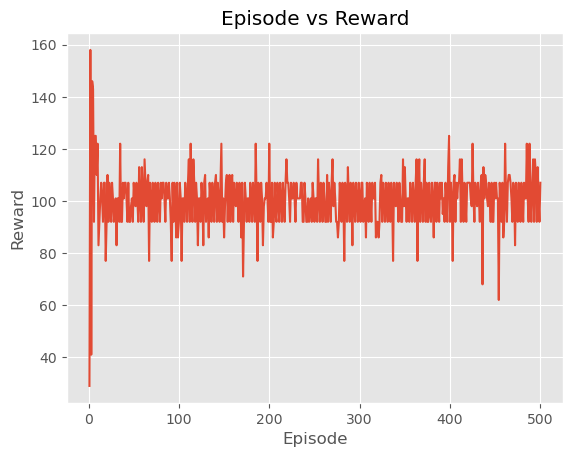

In [1]:
import random
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
from collections import deque
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

style.use('ggplot')


class RPSEnvironment:
    def __init__(self):
        self.action_space = [0, 1, 2]
        self.seqIndex = 0
        self.Opponent_PlayerMode = 'SEQ'
        self.Opponent_PlayerCount = [0, 0, 0]
        self.AgentCount = [0, 0, 0]
        self.window = 10
        self.cumWinRate, self.cumTieRate, self.cumLostRate = None, None, None
        self.cumWinCount, self.cumTieCount, self.cumLostCount = None, None, None
        self.winRateTrend, self.tieRateTrend, self.lostRateTrend = 0, 0, 0
        self.winRateMovingAvg, self.tieRateMovingAvg, self.lostRateMovingAvg = 0, 0, 0
        self.state = np.array([[
            None, None, None,
            self.winRateTrend, self.tieRateTrend, self.lostRateTrend,
            self.winRateMovingAvg, self.tieRateMovingAvg, self.lostRateMovingAvg
        ]])

    def reset(self):
        self.cumWinRate, self.cumTieRate, self.cumLostRate = 0, 0, 0
        self.cumWinCount, self.cumTieCount, self.cumLostCount = 0, 0, 0
        self.winRateTrend, self.tieRateTrend, self.lostRateTrend = 0, 0, 0
        self.winRateMovingAvg, self.tieRateMovingAvg, self.lostRateMovingAvg = 0, 0, 0
        return np.array([0, 0, 0, 0, 0, 0, 0, 0, 0])

    def step(self, action, moveCount, stage):
        Opponent_PlayerMove = MoveGenerator(self, self.Opponent_PlayerMode, stage)
        self.Opponent_PlayerCount[Opponent_PlayerMove] += 1
        AgentMove = action
        self.AgentCount[AgentMove] += 1

        win, tie, lost = 0, 0, 0
        if AgentMove == Opponent_PlayerMove:
            self.cumTieCount, tie = self.cumTieCount + 1, 1
        elif (AgentMove - Opponent_PlayerMove == 1) or (AgentMove - Opponent_PlayerMove == -2):
            self.cumWinCount, win = self.cumWinCount + 1, 1
        else:
            self.cumLostCount, lost = self.cumLostCount + 1, 1

        self.cumWinRate = self.cumWinCount / moveCount
        self.cumTieRate = self.cumTieCount / moveCount
        self.cumLostRate = self.cumLostCount / moveCount

        tmp = [0, 0, 0]
        self.winRateTrend, self.tieRateTrend, self.lostRateTrend = 0, 0, 0
        if moveCount >= self.window:
            if self.winRateMovingAvg < tmp[0]:
                self.winRateTrend = 1
            else:
                self.winRateTrend = 0
            if self.tieRateMovingAvg < tmp[1]:
                self.tieRateTrend = 1
            else:
                self.tieRateTrend = 0
            if self.lostRateMovingAvg < tmp[2]:
                self.lostRateTrend = 1
            else:
                self.lostRateTrend = 0
            self.winRateMovingAvg, self.tieRateMovingAvg, self.lostRateMovingAvg = tmp[0], tmp[1], tmp[2]

        if win == 1:
            reward = 10  # Increase the reward for winning
        elif tie == 1:
            reward = 1
        elif lost == 1:
            reward = -5  # Increase the penalty for losing

        dim = self.state.shape[1]
        self.state = np.array([
            win, tie, lost,
            self.winRateTrend, self.tieRateTrend, self.lostRateTrend,
            self.winRateMovingAvg, self.tieRateMovingAvg, self.lostRateMovingAvg
        ]).reshape(1, dim)

        if self.seqIndex >= 31:
            done = True
        else:
            done = False
        return self.state, reward, done, dim


class ModelBasedDQN:
    def __init__(self, env):
        self.env = env
        self.memory = deque(maxlen=2000)
        self.gamma = 0.9  # Increasing the discount factor to give more weight to future rewards
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995  # Reduce the exploration rate gradually
        self.learning_rate = 0.001  # Adjust the learning rate
        self.tau = .125
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.TDtargetdelta, self.TDtarget = [], []
        self.Qmax = []

    def create_model(self):
        model = Sequential()
        state_shape = self.env.state.shape[1]
        model.add(Dense(24, input_dim=state_shape, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(len(self.env.action_space)))
        model.compile(loss="mean_squared_error", optimizer=Adam(lr=self.learning_rate))
        return model

    def action(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return random.choice(self.env.action_space)
        else:
            self.Qmax.append(np.max(self.model.predict(state)[0]))
            return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def experience_replay(self):
        batch_size = 32
        if len(self.memory) < batch_size:
            return
        samples = random.sample(self.memory, batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = np.max(self.target_model.predict(new_state)[0])
                TDtarget = reward + Q_future * self.gamma
                self.TDtarget.append(TDtarget)
                self.TDtargetdelta.append(TDtarget - target[0][action])
                target[0][action] = TDtarget
            self.model.fit(state, target, epochs=1, verbose=0)

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)


def MoveGenerator(env, mode, stage):
    dict = {'r': 0, 'p': 1, 's': 2}
    seqlist = 'rps'
    env.seqIndex = 0 if env.seqIndex == len(seqlist) - 1 else env.seqIndex + 1
    return dict[seqlist[env.seqIndex]]


def main():
    episodes, trial_len = 500, 50
    env = RPSEnvironment()
    dqn_agent = ModelBasedDQN(env)

    print('STARTING THE GAME with %s episodes each with %s moves' % (episodes, trial_len), '\n')

    rewards = []  # List to store rewards for each episode

    for episode in range(episodes):
        cur_state = env.reset().reshape(1, -1)
        cum_reward = 0

        for step in range(trial_len):
            action = dqn_agent.action(cur_state)
            new_state, reward, done, _ = env.step(action, step + 1, episode)
            cum_reward += reward
            dqn_agent.remember(cur_state, action, reward, new_state, done)
            cur_state = new_state
            if done:
                break

        rewards.append(cum_reward)  # Store cumulative reward for the episode

        win_rate = env.cumWinRate
        tie_rate = env.cumTieRate
        lose_rate = env.cumLostRate
        p1_rock_rate = env.AgentCount[0] / trial_len
        p1_paper_rate = env.AgentCount[1] / trial_len
        p1_scissors_rate = env.AgentCount[2] / trial_len
        p2_rock_rate = env.Opponent_PlayerCount[0] / trial_len
        p2_paper_rate = env.Opponent_PlayerCount[1] / trial_len
        p2_scissors_rate = env.Opponent_PlayerCount[2] / trial_len
        avg_reward = cum_reward / trial_len
        avg_qmax = sum(dqn_agent.Qmax) / trial_len

        print('EPISODE', episode + 1)
        print('WIN RATE %.2f      tie rate %.2f lose rate %.2f' % (win_rate, tie_rate, lose_rate))
        print('P1 rock rate: %.2f paper rate: %.2f scissors rate: %.2f' % (p1_rock_rate, p1_paper_rate, p1_scissors_rate))
        print('P2 rock rate: %.2f paper rate: %.2f scissors rate: %.2f' % (p2_rock_rate, p2_paper_rate, p2_scissors_rate))
        print('Avg reward: %.2f Avg Qmax: %.2f' % (avg_reward, avg_qmax))

        # Get agent's predicted move based on the current state
        agent_move = np.argmax(dqn_agent.model.predict(cur_state)[0])
        print('Agent thinking:', ['rock', 'paper', 'scissors'][agent_move])
        print()

        dqn_agent.Qmax = []

        if episode == episodes - 1:
            fig = plt.figure(figsize=(12, 12))
            plt.subplots_adjust(wspace=0.2, hspace=0.3)
            plt.show()

    # Plot the graph of episode versus reward
    plt.plot(range(1, episodes + 1), rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.title('Episode vs Reward')
    plt.show()


if __name__ == "__main__":
    main()

